In [4]:
from typing import List, Mapping
from itertools import zip_longest, chain
from glob import iglob
from pickle import load
from functools import partial, reduce

from scipy.ndimage.filters import gaussian_filter
import pandas as pd
import numpy as np
from numpy.random import normal, choice, rand
from numpy.polynomial.legendre import Legendre
import matplotlib.pyplot as plt
from h5py import File

from vmitools import (
    abel_inverse, finite_legendre_transform_in_theta,
    interp, tohist, transpose_linearly, transpose_to_drdomega, transpose_to_drdth,
    mrot, mhorshear, msqueeze,
)

In [46]:
filenames = [
#     "/data/Step601N2/combined/335/335_1_12.h5",
    "/data/Step601N2/combined/336/336_10_10.h5",
    # "/data/Step601N2/combined/Run_330-Run_332/DL_10_PE_-Inf-Inf_SI_0-Inf.h5",
]

In [47]:
def read_file(filename):
    try:
        with File(filename, "r") as f:
            imgs = f['/vmi/data'][...].astype('float')
            n = f['/signal_shots'][...]
            delays = f['/IR_delays'][...]
            atmax = f['/peak_wavelengths'][...]
            i0, i1, ix, iy = imgs.shape
            indexes = (delays * atmax.T).reshape(-1)
    except KeyError:
        print("Got an error at: {}".format(filename))
        return None
    return pd.DataFrame({
        'sum': [img for img in (imgs * n[:, :, None, None]).reshape(-1, ix, iy)],
        'count': n.reshape(-1),
    }, index=pd.MultiIndex.from_product(
        [delays.reshape(-1), atmax.reshape(-1)],
        names=['delays', 'atmax'],
    ))


sumup = partial(reduce, partial(pd.DataFrame.add, fill_value=0))
summed = sumup(read_file(fn) for fn in filenames)
summed

sum  count
delays    atmax                                                              
-6.999999 80.588221  [[-2.666666666666586, -47.33333333333343, -4.6...   11.0
          80.595044  [[20.26086956521739, 19.95652173913045, 10.478...   21.0
          80.601867  [[165.15625000000014, 112.81250000000071, 44.8...  130.0
          80.608689  [[447.52419354838776, 487.73387096773854, 353....  267.0
          80.615512  [[249.96808510638317, 456.14893617021266, 299....  145.0
          80.622334  [[415.0000000000013, 619.1290322580617, 434.96...  284.0
          80.629157  [[146.97297297297268, 6.027027027026804, 90.81...   76.0
          80.635980  [[152.42857142857076, 44.92857142857105, 56.07...   58.0
          80.642802  [[-5.0, -26.0, 11.0, -22.0, 14.0, -12.0, 3.0, ...    4.0
          80.649625  [[15.0, -30.0, -7.0, -23.0, -16.0, 2.0, 26.0, ...    4.0
-6.888884 80.588221  [[20.0, -54.0, 27.0, 39.0, 18.0, 13.0, -42.0, ...    8.0
          80.595044  [[-10.999999999999886, -50.00000000000017, 15....   28.0
          80.601867  [[39.10416666666663, 37.416666666666615, 61.31...   91.0
          80.608689  [[176.31192660550596, 242.16513761467996, 161....  187.0
          80.615512  [[214.38888888888974, 48.16666666666765, 205.2...  141.0
          80.622334  [[488.6385542168679, 351.0421686746991, 310.31...  275.0
          80.629157  [[233.02439024390196, 277.2926829268293, 150.9...   94.0
          80.635980  [[176.11538461538453, 153.28846153846106, 136....  113.0
          80.642802  [[34.00000000000003, 135.00000000000009, -15.3...   22.0
          80.649625  [[18.999999999999943, 84.99999999999994, 3.0, ...   12.0
-6.777769 80.588221  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    1.0
          80.595044  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    4.0
          80.601867  [[21.578947368420984, 51.73684210526322, -15.6...   21.0
          80.608689  [[128.66666666666674, 114.83333333333411, 127....   86.0
          80.615512  [[120.4871794871792, 123.07692307692261, 73.07...   83.0
          80.622334  [[399.89130434782555, 802.5362318840596, 481.0...  263.0
          80.629157  [[292.461538461539, 532.692307692306, 388.5384...  174.0
          80.635980  [[406.4580152671749, 616.648854961829, 374.832...  247.0
          80.642802  [[25.5625000000002, 29.374999999999716, 100.81...   45.0
          80.649625  [[21.692307692307168, 112.07692307692355, 47.6...   56.0
...                                                                ...    ...
-6.222197 80.588221  [[3.999999999999943, 9.500000000000199, 35.025...   47.0
          80.595044  [[22.090909090908667, 41.8181818181817, 13.818...   92.0
          80.601867  [[43.53608247422875, 192.3195876288666, -11.14...  177.0
          80.608689  [[46.55045871559878, 425.88990825687944, 77.89...  260.0
          80.615512  [[5.000000000000654, -223.9999999999992, 70.99...  126.0
          80.622334  [[85.99999999999937, 252.00000000000102, -11.0...  180.0
          80.629157  [[47.18518518518508, -76.51851851851876, -5.11...   58.0
          80.635980  [[53.9411764705882, 98.70588235294115, 37.5294...   45.0
          80.642802  [[-10.0, 32.0, -2.0, -2.0, 4.0, -6.0, 24.0, -1...    4.0
          80.649625  [[-3.0, -6.0, 4.0, 1.0, 3.0, -2.0, -1.0, -4.0,...    1.0
-6.111082 80.588221  [[-6.999999999999915, -2.7777777777778283, 11....   17.0
          80.595044  [[32.50000000000014, 165.0, 15.000000000000426...   55.0
          80.601867  [[-27.82051282051259, 31.58974358974325, 19.25...  142.0
          80.608689  [[132.00787401574814, -140.6220472440943, -35....  244.0
          80.615512  [[31.243243243242205, -254.8378378378373, -41....  132.0
          80.622334  [[-66.60169491525618, 359.1864406779665, -31.9...  259.0
          80.629157  [[30.953488372092252, -93.90697674418695, -3.6...   81.0
          80.635980  [[8.99999999999983, 65.0, -10.999999999999545,...   52.0
          80.642802  [[24.000000000000057, -39.00000000000006, 5.99...   10.0
          8

In [48]:
ind = summed.index[0][0]
summed = summed.loc[ind:ind]
summed

sum  count
delays    atmax                                                              
-6.999999 80.588221  [[-2.666666666666586, -47.33333333333343, -4.6...   11.0
          80.595044  [[20.26086956521739, 19.95652173913045, 10.478...   21.0
          80.601867  [[165.15625000000014, 112.81250000000071, 44.8...  130.0
          80.608689  [[447.52419354838776, 487.73387096773854, 353....  267.0
          80.615512  [[249.96808510638317, 456.14893617021266, 299....  145.0
          80.622334  [[415.0000000000013, 619.1290322580617, 434.96...  284.0
          80.629157  [[146.97297297297268, 6.027027027026804, 90.81...   76.0
          80.635980  [[152.42857142857076, 44.92857142857105, 56.07...   58.0
          80.642802  [[-5.0, -26.0, 11.0, -22.0, 14.0, -12.0, 3.0, ...    4.0
          80.649625  [[15.0, -30.0, -7.0, -23.0, -16.0, 2.0, 26.0, ...    4.0

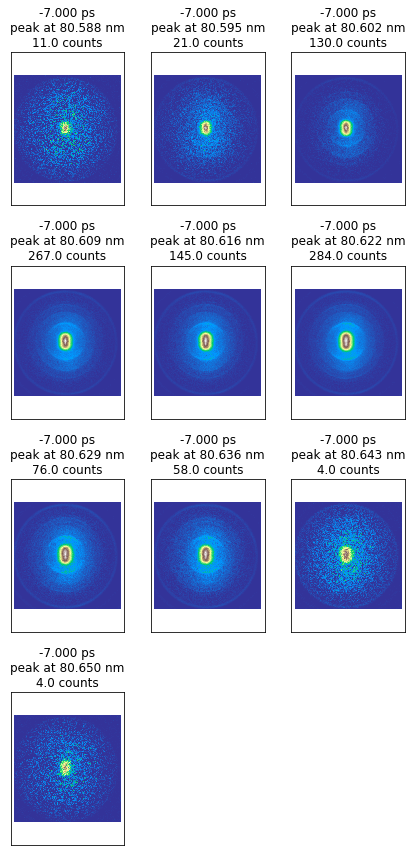

In [62]:
df = pd.DataFrame({
    'img': (summed['sum'] / summed['count']).apply(partial(np.einsum, 'ij->ji')),
    'n': summed['count'],
})

plt.figure(figsize=(6, 12))
for i, ((dt, atmax), img, n) in enumerate(df[['img', 'n']].itertuples()):
    plt.subplot(4, 3, i+1)
    plt.title(f"{dt:.3f} ps\npeak at {atmax:.3f} nm\n{n} counts")
    plt.pcolormesh(img.T, cmap='terrain')
    plt.axis("equal")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.clim(0, None)
plt.tight_layout()
plt.show()

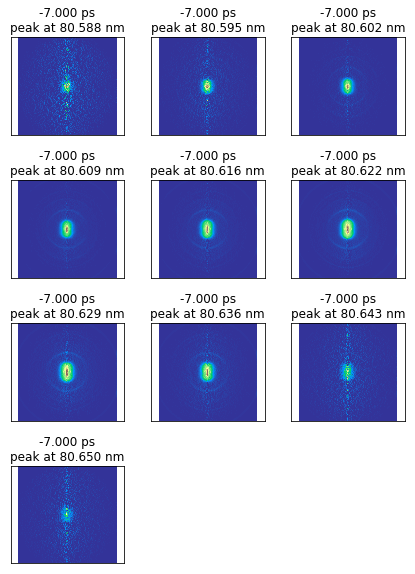

In [63]:
zedges = np.arange(-400, 400 + 1)
redges, thedges = np.linspace(0, 400, 400 + 1), np.linspace(-np.pi, np.pi, 360 + 1)
r = (redges[1:] + redges[:-1]) / 2
th = (thedges[1:] + thedges[:-1]) / 2


def invert_img(d):
    img = d['img']
    img = gaussian_filter(img, 2)
    xn, yn = img.shape
    xedges = np.arange(xn + 1)
    yedges = np.arange(yn + 1)
    f = interp(img, xedges, yedges)
    g = transpose_linearly(f, np.eye(2), x0=np.array([437, 458]))
    transformed = tohist(g, zedges, zedges)

    dz = zedges[1:] - zedges[:-1]
    inverted = abel_inverse(transformed, zedges) * dz[None, :]  # shape: (r, z)
    sliced = interp(inverted, zedges, zedges)  # (rho, z) -> intensity
    hist_indrdomega = tohist(transpose_to_drdomega(sliced), redges, thedges)  # (r, th) -> intensity
    hist_indrdth = tohist(transpose_to_drdth(sliced), redges, thedges)  # (r, th) -> intensity
    return pd.Series({
        'inverted': inverted,
        'hist_indrdth': hist_indrdth,
        'hist_indrdomega': hist_indrdomega,
    })


df = df.merge(df.apply(invert_img, axis=1), left_index=True, right_index=True)


plt.figure(figsize=(6, 12))
for i, ((dt, atmax), img, n) in enumerate(df[['inverted', 'n']].itertuples()):
    plt.subplot(6, 3, i+1)
    plt.title(f"{dt:.3f} ps\npeak at {atmax:.3f} nm")
    plt.pcolormesh(img.T, cmap='terrain')
    plt.axis("equal")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.clim(0, None)
plt.tight_layout()
plt.show()

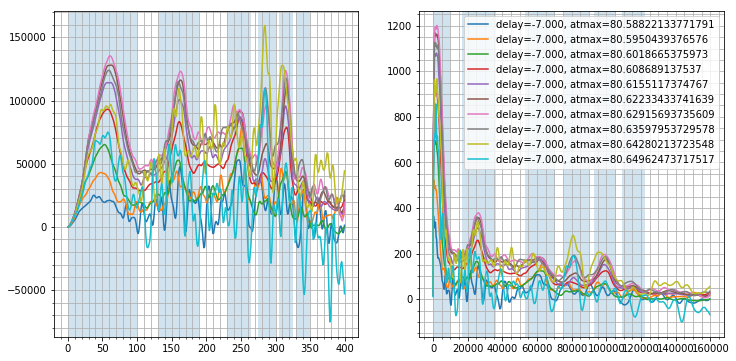

In [56]:
roi = [
    [0, 100],
    [130, 190],
    [230, 265],
    [275, 300],
    [305, 325],
    [330, 350],
]


def f(hist):
    return hist.sum(1)


def intergrateit(hist, fr, to, x=None, **kwargs):
    if x is None:
        x = np.arange(len(hist))
    where = (fr < x) & (x < to)
    return hist[where].sum(**kwargs)


def project_to_pn(hist, n):
    _, coeff, _ = finite_legendre_transform_in_theta(
        hist, thedges, n + 1,
    )  # Shapes of returns: (n, r) (n, r) (n, th)
    return coeff[n]/coeff[0]


for i, (fr, to) in enumerate(roi):
    df[f'summed{i}_rdist'] = df['hist_indrdth'].apply(intergrateit, fr=fr, to=to, x=r)
    df[f'summed{i}_pad'] = df['hist_indrdomega'].apply(intergrateit, fr=fr, to=to, x=r, axis=0)
    df[f'summed{i}_beta2'] = df[f'summed{i}_pad'].apply(project_to_pn, n=2)
    df[f'summed{i}_beta4'] = df[f'summed{i}_pad'].apply(project_to_pn, n=4)


plt.figure(figsize=(12, 6))
plt.subplot(121)
for (dt, atmax), dist in df['hist_indrdth'].apply(f).items():
    plt.plot(r, dist, label=f"delay={dt:.3f},atmax={atmax:.3f}")
plt.minorticks_on()
plt.grid(True, which='both')

for fr, to in roi:
    plt.axvspan(fr, to, alpha=0.2)

plt.subplot(122)
for (dt, atmax), dist in df['hist_indrdth'].apply(f).items():
    plt.plot(r**2, dist/2/r, label=f"delay={dt:.3f}, atmax={atmax}")
plt.minorticks_on()
plt.grid(True, which='both')

for fr, to in roi:
    plt.axvspan(fr**2, to**2, alpha=0.2)

plt.legend()
plt.show()

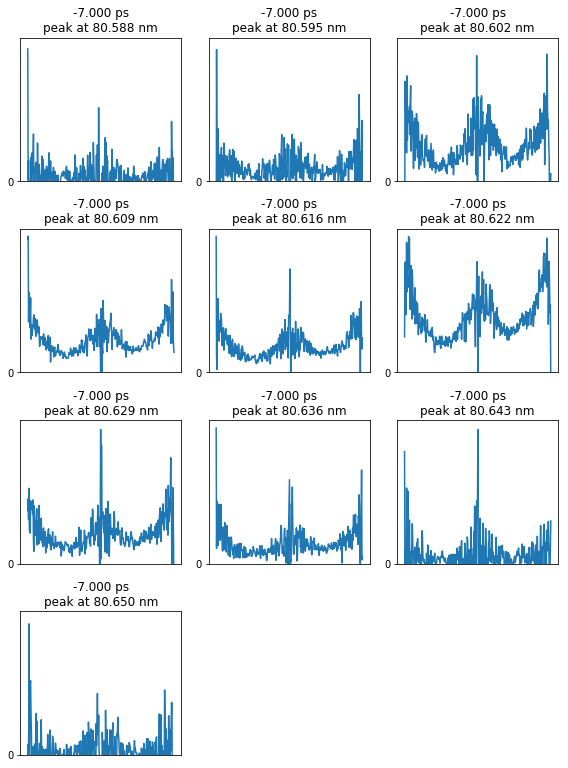

In [58]:
plt.figure(figsize=(8, 16))
for i, ((dt, atmax), pad) in enumerate(df['summed2_pad'].items()):
    plt.subplot(6, 3, i+1)
    plt.title(f"{dt:.3f} ps\npeak at {atmax:.3f} nm")
    plt.plot(th, pad)
    plt.xticks([], [])
    plt.yticks([0], [0])
    plt.ylim(0, None)
plt.tight_layout()
plt.show()

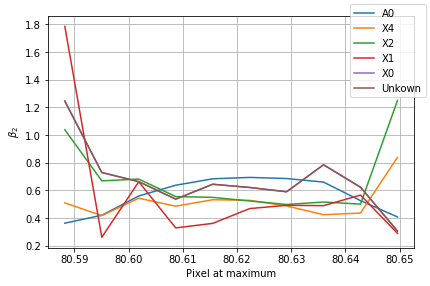

In [59]:
at = df.index[0][0]


def norm(arr):
    return arr/arr.sum()


plt.figure()
plt.xlabel("Pixel at maximum")
plt.ylabel(r"$\beta_2$")
plt.plot(df.loc[at]['summed0_beta2'], label='A0')
plt.plot(df.loc[at]['summed1_beta2'], label='X4')
plt.plot(df.loc[at]['summed2_beta2'], label='X2')
plt.plot(df.loc[at]['summed3_beta2'], label='X1')
plt.plot(df.loc[at]['summed4_beta2'], label='X0')
plt.plot(df.loc[at]['summed4_beta2'], label='Unkown')
# plt.ylim(0, None)
plt.grid(True)
plt.figlegend()
plt.tight_layout()
plt.show()

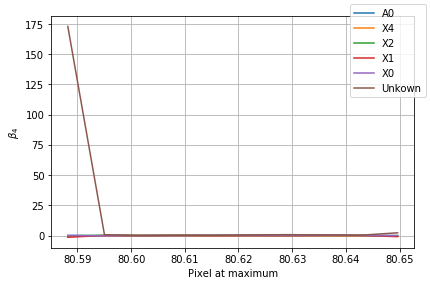

In [60]:
at = df.index[0][0]


def norm(arr):
    return arr/arr.sum()


plt.figure()
plt.xlabel("Pixel at maximum")
plt.ylabel(r"$\beta_4$")
plt.plot(df.loc[at]['summed0_beta4'], label='A0')
plt.plot(df.loc[at]['summed1_beta4'], label='X4')
plt.plot(df.loc[at]['summed2_beta4'], label='X2')
plt.plot(df.loc[at]['summed3_beta4'], label='X1')
plt.plot(df.loc[at]['summed4_beta4'], label='X0')
plt.plot(df.loc[at]['summed5_beta4'], label='Unkown')
# plt.ylim(0, None)
plt.grid(True)
plt.figlegend()
plt.tight_layout()
plt.show()

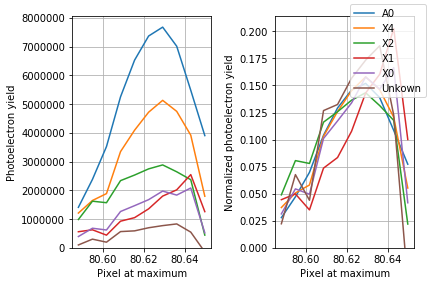

In [61]:
at = df.index[0][0]


def norm(arr):
    return arr/arr.sum()


plt.figure()
plt.subplot(121)
plt.xlabel("Pixel at maximum")
plt.ylabel("Photoelectron yield")
plt.plot(df.loc[at]['summed0_rdist'], label='A0')
plt.plot(df.loc[at]['summed1_rdist'], label='X4')
plt.plot(df.loc[at]['summed2_rdist'], label='X2')
plt.plot(df.loc[at]['summed3_rdist'], label='X1')
plt.plot(df.loc[at]['summed4_rdist'], label='X0')
plt.plot(df.loc[at]['summed5_rdist'], label='Unkown')
plt.ylim(0, None)
plt.grid(True)
plt.figlegend()

plt.subplot(122)
plt.xlabel("Pixel at maximum")
plt.ylabel("Normalized photoelectron yield")
plt.plot(norm(df.loc[at]['summed0_rdist']), label='A0')
plt.plot(norm(df.loc[at]['summed1_rdist']), label='X4')
plt.plot(norm(df.loc[at]['summed2_rdist']), label='X2')
plt.plot(norm(df.loc[at]['summed3_rdist']), label='X1')
plt.plot(norm(df.loc[at]['summed4_rdist']), label='X0')
plt.plot(norm(df.loc[at]['summed5_rdist']), label='Unkown')
plt.ylim(0, None)
plt.grid(True)
# plt.figlegend()
plt.tight_layout()
plt.show()